<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/makemore_v3_mlp_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-03 09:06:18--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-07-03 09:06:18 (6.56 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3277
  10000/ 200000: 2.2796
  20000/ 200000: 2.4154
  30000/ 200000: 2.6209
  40000/ 200000: 1.9621
  50000/ 200000: 2.3349
  60000/ 200000: 2.4446
  70000/ 200000: 2.1641
  80000/ 200000: 2.3063
  90000/ 200000: 2.2793
 100000/ 200000: 1.8783
 110000/ 200000: 2.1199
 120000/ 200000: 1.9415
 130000/ 200000: 2.2646
 140000/ 200000: 2.2047
 150000/ 200000: 2.1859
 160000/ 200000: 1.8602
 170000/ 200000: 1.7062
 180000/ 200000: 1.9129
 190000/ 200000: 1.9112


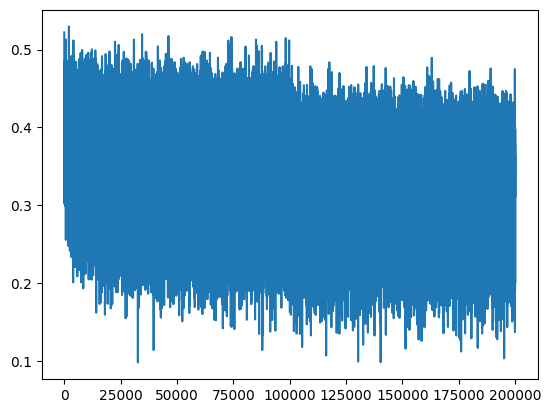

In [9]:
plt.plot(lossi)

We initialized the W1 to be very close to zero to get a lower loss initially. Because it will help the gradient move onto the toughest road to optimize the loss function. It will not go move to the smooth part. So there is no smoothly decreasing line in the graph.

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0688300132751465
val 2.131155490875244


**Problems** with value of **h** L

In [13]:
h.view(-1).tolist()

[0.9999048113822937,
 0.26688188314437866,
 -0.9834985136985779,
 -0.9908811450004578,
 0.9999523162841797,
 0.9976971745491028,
 0.9947482347488403,
 0.9999921917915344,
 0.6829972863197327,
 -0.6395760774612427,
 -0.8795188665390015,
 0.9563055634498596,
 0.9997198581695557,
 -0.30230817198753357,
 -0.2226361483335495,
 0.8418723344802856,
 1.0,
 -0.8996573090553284,
 -1.0,
 0.9998846650123596,
 0.9999983906745911,
 -0.9906260371208191,
 0.9997798800468445,
 0.999640941619873,
 -0.999886691570282,
 0.9999952912330627,
 -0.9994487762451172,
 0.9999924898147583,
 -0.9999858140945435,
 0.9999992847442627,
 -0.30844956636428833,
 -0.9999998807907104,
 -0.9999973177909851,
 -0.9992444515228271,
 -0.9999862909317017,
 0.9857614636421204,
 -0.9880340099334717,
 -0.9999936819076538,
 -0.7493188977241516,
 0.9684197902679443,
 0.9882200360298157,
 -1.0,
 -0.999487042427063,
 -1.0,
 0.0936264619231224,
 -0.9777957797050476,
 -0.9864414930343628,
 -1.0,
 1.0,
 0.9971705675125122,
 0.72605961561